In [1]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier




<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.utils.helpers import get_emotion_abrs_from_ids
from global_config import *

# Paths

In [4]:
output_path = os.path.join(ROOT_DIR, "files/out/functionals/supervised_learning/audio/")

# Load and shuffle data

In [5]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(output_path + 'audio_data_egemaps_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,emotion_1_id,filename,video_id,group
2390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904,0.000000,0.269371,0.000000,...,0.000000,0.000000,0.000000,0.338190,0.000000,0.484173,0,A327_reg_v_4,A327,13
2146,0.615766,0.125523,0.577642,0.621526,0.628153,0.093323,0.158369,0.063086,0.275682,0.006283,...,0.070204,0.178824,0.132388,0.035130,0.211113,0.688699,19,A218_ins_p_4,A218,13
9215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904,0.000000,0.269371,0.000000,...,0.000000,0.000000,0.000000,0.119961,0.000000,0.418530,30,A327_nos_v_2,A327,13
8032,0.577212,0.261748,0.496733,0.580822,0.645519,0.237018,0.322266,0.333692,0.280771,0.022147,...,0.385650,0.064000,0.123960,0.003292,0.013597,0.665966,5,A332_adm_p_4,A332,7
10590,0.440892,0.095890,0.424234,0.433494,0.454973,0.059078,0.105777,0.005007,0.273507,0.006692,...,0.190582,0.078824,0.097042,0.013307,0.052891,0.594039,37,A303_disa_p_2,A303,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7192,0.473751,0.095240,0.450429,0.478119,0.486837,0.068337,0.158857,0.061007,0.273558,0.008001,...,0.079020,0.047059,0.093692,0.046625,0.169227,0.548722,40,A67_gui_p_2,A67,14
4848,0.607794,0.062079,0.594904,0.607066,0.608222,0.038520,0.128740,0.031944,0.277090,0.025470,...,0.144235,0.065294,0.148819,0.022309,0.094598,0.604268,30,A74_nos_v_2,A74,8
3912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100904,0.000000,0.269371,0.000000,...,0.000000,0.000000,0.000000,0.079812,0.000000,0.494490,31,A200_sar_p_1,A200,5
3768,0.467435,0.165203,0.427748,0.477574,0.495876,0.114826,0.142009,0.061708,0.269772,0.011300,...,0.122857,0.064314,0.107287,0.025983,0.129604,0.657703,30,A65_nos_p_4,A65,1


# Other functions

In [6]:
from sklearn.metrics import confusion_matrix

def calculate_conf_matrix(X_train, X_val, y_train, y_val, clf):
    # train classifier on training sets 
    clf.fit(X_train,y_train)

    # Compute results (validation dataset)    
    y_pred = clf.predict(X_val)                       # Predict class

    # compare true validation results (y_val) with prediction (y_pred)
    # Compute confusion matrix
    return confusion_matrix(y_val,
                            y_pred,
                            normalize='true'
                            )
    

In [7]:
def iterate_conf_matrices(size, X, y, cv, clf):
    # Initialize a matrix of zeros to store results
    conf_mat_avg = np.zeros([size, size])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        conf_mat_avg += calculate_conf_matrix(X_train, X_val, y_train, y_val, clf)
    
    # compute the average scores by dividing with number of groups
    return conf_mat_avg/n_groups

In [8]:
def get_conf_matrix(X, y, cv, clf):
    """
    Produces a confusion matrix by iterating and averageing the confusion matrix for each validation set
    :return: confusion matrix in the form of a dataframe
    """
    # get emotion_ids
    emotion_ids = y.unique()
    
    # compute the average scores by dividing with number of groups
    conf_mat_avg = iterate_conf_matrices(len(emotion_ids), X, y, cv, clf,)
    
    # get emotion abreviations
    emotion_abrs = get_emotion_abrs_from_ids(emotion_ids)
    
    # create dataframe with lists of emotion ids as row and column names
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_abrs), list(emotion_abrs))
    
    # sort columns
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    return df_cm

In [9]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [10]:
def save_conf_matrix(file_name):
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')       

# Define scoring function

In [11]:
def evaluate_scores(X, y, groups, clf, scoring_method):
    # get scores
    scores = cross_validate(X=X, y=y,
                            estimator           = clf,
                            scoring             = [scoring_method],
                            cv                  = logo.split(X=X,groups=groups),
                            verbose             = 1,
                            n_jobs              = -1,
                            return_train_score  = True                        
                           )
    
    print('\nprinting {} measures'.format(scoring_method))
    print('avg (train):', np.mean(scores['train_{}'.format(scoring_method)]))
    print('std (train):', np.std(scores['train_{}'.format(scoring_method)]))
    print('avg (validation):', np.mean(scores['test_{}'.format(scoring_method)]))
    print('std (validation):', np.std(scores['test_{}'.format(scoring_method)]))

# Training and testing

### Get X, y and groups from the training data set

In [13]:
# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=["filename", "video_id", "emotion_1_id", "group"])
y = train_shuffled_df.emotion_1_id
groups = train_shuffled_df.group
n_groups = len(groups.unique())

# Elastic Net SGD Classifier

### Cross validate with best parameters

{'alpha': 0.0001, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'loss': 'log', 'max_iter': 2500, 'n_iter_no_change': 150, 'penalty': 'elasticnet', 'random_state': 27}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing accuracy measures
avg (train): 0.09770094015403165
std (train): 0.002664720495781814
avg (validation): 0.07243592058142398
std (validation): 0.01600297812041988


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing roc_auc_ovo_weighted measures
avg (train): 0.7156613682559346
std (train): 0.0025280144641923936
avg (validation): 0.6710921069590101
std (validation): 0.03530336644236595


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.3min finished
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(



printing recall_macro measures
avg (train): 0.0981237132646557
std (train): 0.002688596869864874
avg (validation): 0.07269468996987948
std (validation): 0.01573161531889171


/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
<frozen importlib._bootstrap>:219:

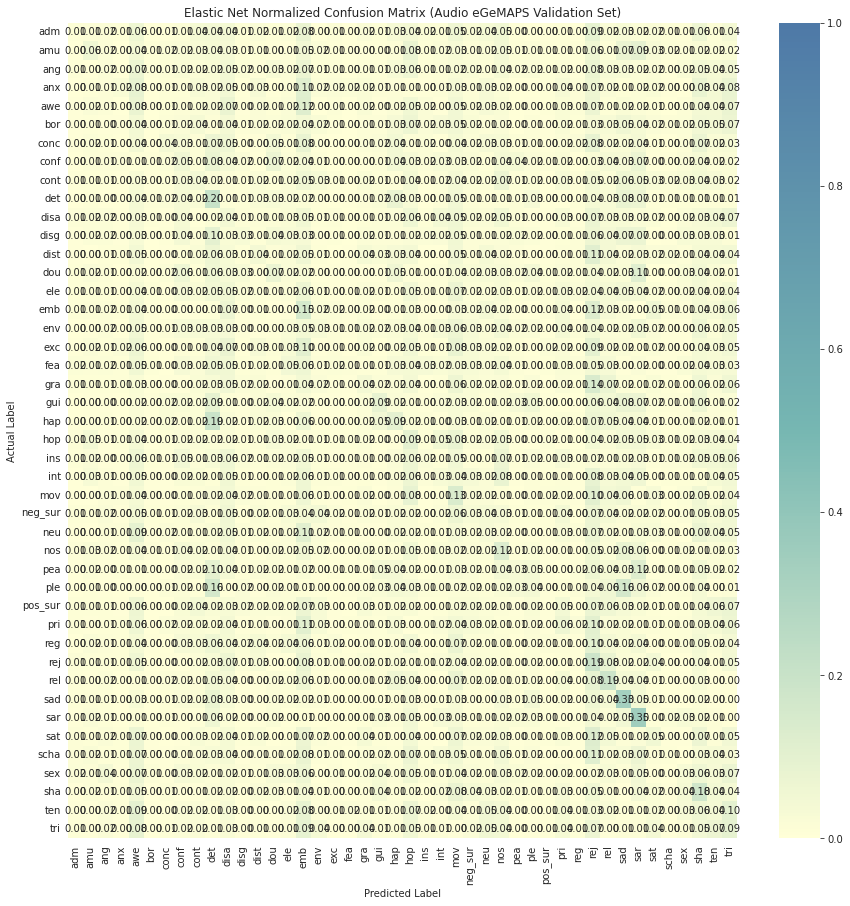

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

logo = LeaveOneGroupOut()

# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))

print(best_params)
                   
clf = SGDClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )

# Plot confusion matrix
plot_conf_matrix(df_cm, title='Elastic Net Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_elastic_net_egemaps_audio.svg')


## kNN

TODO: Might be smart to seed such that every emotion has it's own cluster starting point

{'algorithm': 'ball_tree', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 811, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   37.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   32.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing accuracy measures
avg (train): 0.0686922114423853
std (train): 0.0015796534044226988
avg (validation): 0.05524058850340334
std (validation): 0.013501808146721238


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing roc_auc_ovo_weighted measures
avg (train): 0.6741424626088912
std (train): 0.002282909945453076
avg (validation): 0.637956220315053
std (validation): 0.03076349115043128


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   30.9s finished



printing recall_macro measures
avg (train): 0.06854447068015526
std (train): 0.0015800985285984344
avg (validation): 0.05531356143994866
std (validation): 0.013466688036113682


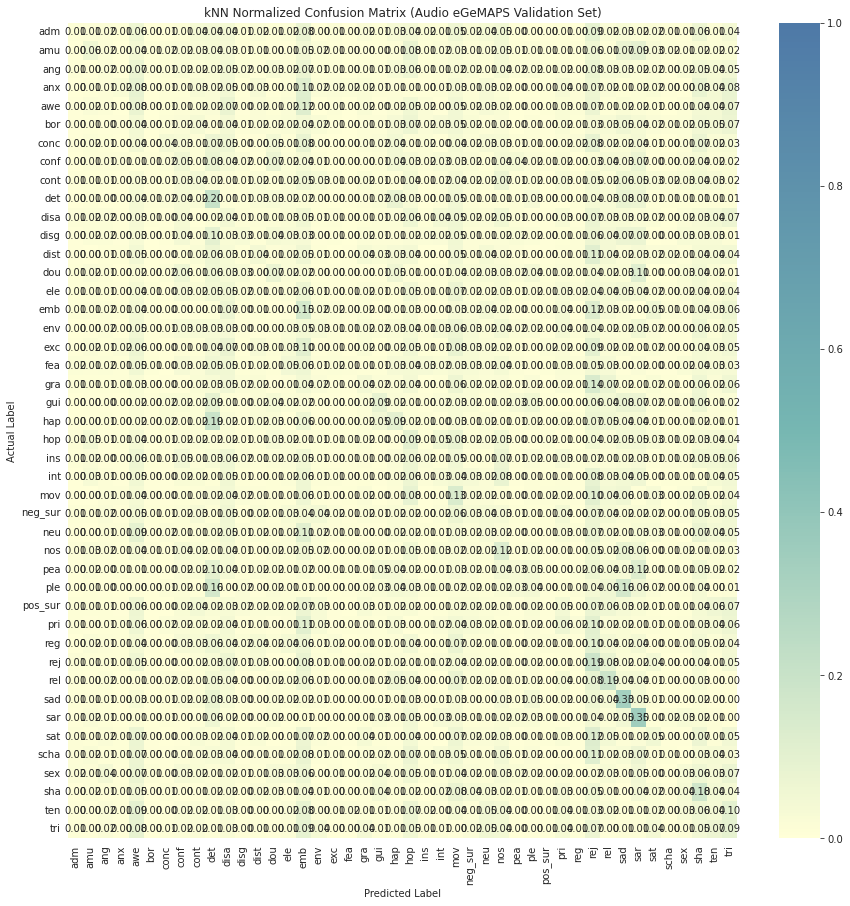

In [15]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))

print(best_params)
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Plot confusion matrix
plot_conf_matrix(df_cm, title='kNN Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_knn_egemaps_audio.svg')

## Decision Tree


{'splitter': 'best', 'random_state': 27, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 62, 'max_depth': 40, 'criterion': 'entropy', 'class_weight': 'balanced'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing accuracy measures
avg (train): 0.04751391678303471
std (train): 0.0011117535128728514
avg (validation): 0.03943190572603922
std (validation): 0.006324273244146763


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing roc_auc_ovo_weighted measures
avg (train): 0.6254165206555424
std (train): 0.003128097389246632
avg (validation): 0.5999190386809501
std (validation): 0.02153633843377413


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.6s finished



printing recall_macro measures
avg (train): 0.047727659027910214
std (train): 0.0010841082774289703
avg (validation): 0.039610201380723215
std (validation): 0.006036482638101808


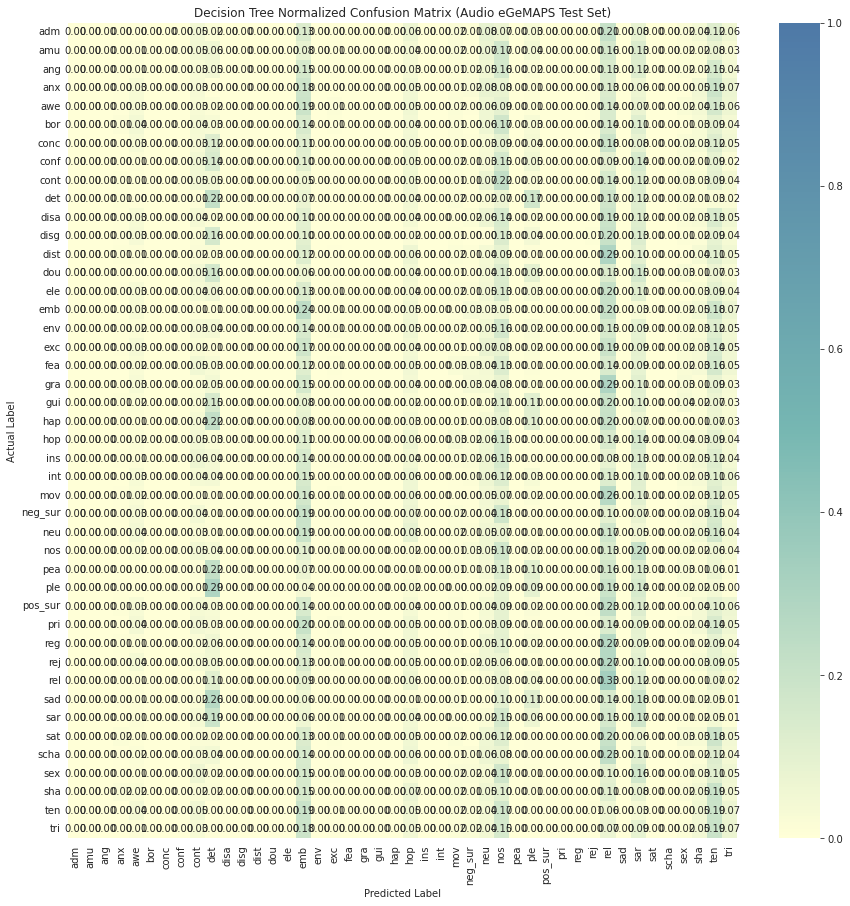

In [16]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_decision_tree_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))

print(best_params)
                   
clf = DecisionTreeClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Decision Tree Normalized Confusion Matrix (Audio eGeMAPS Test Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_tree_egemaps_audio.svg')

## Random Forest

{'random_state': 27, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing accuracy measures
avg (train): 0.9892359334904564
std (train): 0.0023963050172629043
avg (validation): 0.07612969284708748
std (validation): 0.017744873682114838


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.



printing roc_auc_ovo_weighted measures
avg (train): 0.9990728314262424
std (train): 0.00015654678420071283
avg (validation): 0.6725688074548705
std (validation): 0.03474824610747306


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.0min finished
/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



printing recall_macro measures
avg (train): 0.9892441238941064
std (train): 0.002389369632181102
avg (validation): 0.07624514339799593
std (validation): 0.01766298447435539


/home/tim/anaconda3/envs/thesis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.m

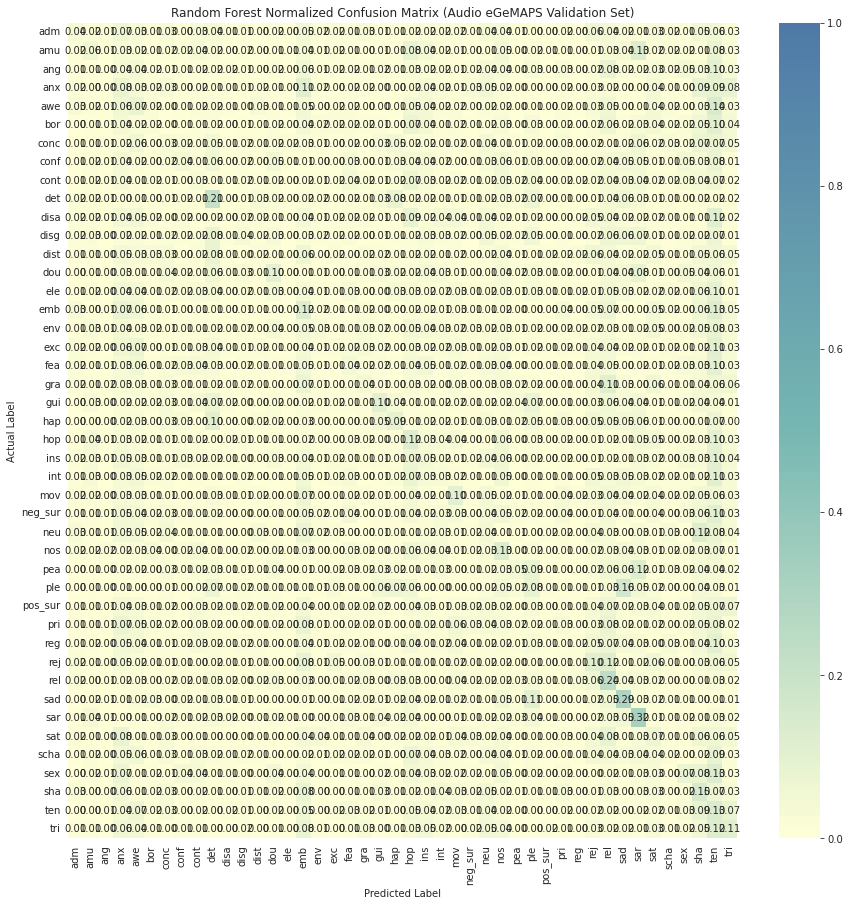

In [17]:
# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_egemaps_audio.sav')
best_params = pickle.load(open(file_path, 'rb'))

print(best_params)
                   
clf = RandomForestClassifier(**best_params)

evaluate_scores(X, y, groups, clf, 'accuracy')
evaluate_scores(X, y, groups, clf, 'roc_auc_ovo_weighted')
evaluate_scores(X, y, groups, clf, 'recall_macro')

# Create confusion matrix
df_cm = get_conf_matrix(X=X,
                        y=y,
                        cv=logo.split(X=X, groups=groups),
                        clf=clf,
                        )
# Plot confusion matrix
plot_conf_matrix(df_cm, title='Random Forest Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')

# Save confusion matrix
save_conf_matrix(file_name='conf_mat_rf_egemaps_audio.svg')